In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [2]:
data = pd.read_csv('../data/num_file/min_10/p040.csv')

In [3]:
print(data)

                  datetime  count
0      2022-04-21 01:40:00    200
1      2022-04-21 01:50:00    833
2      2022-04-21 02:00:00     65
3      2022-04-21 02:10:00      0
4      2022-04-21 02:20:00      0
...                    ...    ...
19495  2022-09-03 10:50:00   4034
19496  2022-09-03 11:00:00   3556
19497  2022-09-03 11:10:00   1082
19498  2022-09-03 11:20:00   3937
19499  2022-09-03 11:30:00   4176

[19500 rows x 2 columns]


If there is no people, use NaN.

In [4]:
data.loc[data['count']==0, 'count'] = np.NaN

In [5]:
print(data)

                  datetime   count
0      2022-04-21 01:40:00   200.0
1      2022-04-21 01:50:00   833.0
2      2022-04-21 02:00:00    65.0
3      2022-04-21 02:10:00     NaN
4      2022-04-21 02:20:00     NaN
...                    ...     ...
19495  2022-09-03 10:50:00  4034.0
19496  2022-09-03 11:00:00  3556.0
19497  2022-09-03 11:10:00  1082.0
19498  2022-09-03 11:20:00  3937.0
19499  2022-09-03 11:30:00  4176.0

[19500 rows x 2 columns]


<Axes: >

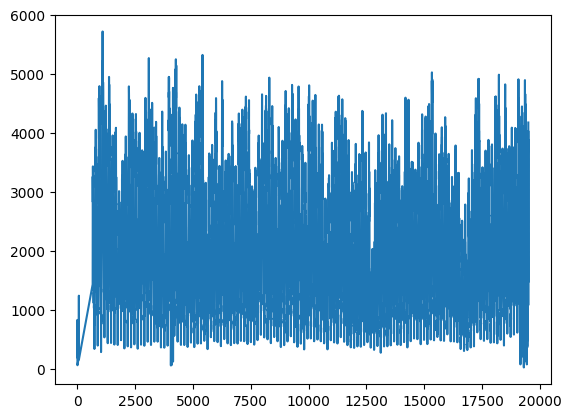

In [6]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

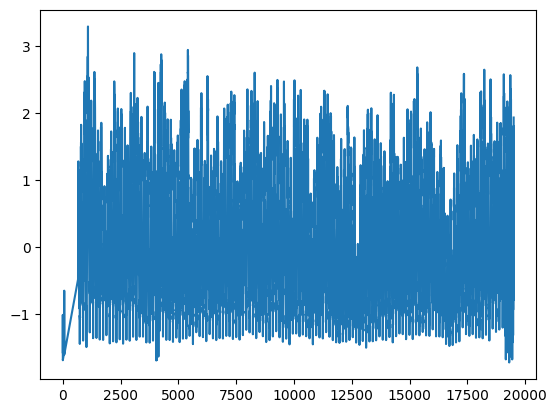

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [8]:
print(data)

                  datetime     count
0      2022-04-21 01:40:00 -1.563824
1      2022-04-21 01:50:00 -1.007215
2      2022-04-21 02:00:00 -1.682532
3      2022-04-21 02:10:00 -1.680572
4      2022-04-21 02:20:00 -1.678611
...                    ...       ...
19495  2022-09-03 10:50:00  1.807486
19496  2022-09-03 11:00:00  1.387171
19497  2022-09-03 11:10:00 -0.788265
19498  2022-09-03 11:20:00  1.722192
19499  2022-09-03 11:30:00  1.932349

[19500 rows x 2 columns]


In [9]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 12

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [10]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [11]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

In [12]:
print(decode_output_data[:, -1, :])

[[-1.66292776]
 [-1.66096731]
 [-1.65900686]
 ...
 [ 1.38717097]
 [-0.78826465]
 [ 1.72219157]]


## Model

In [13]:
from keras.layers import Input, LSTM, BatchNormalization, TimeDistributed, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [14]:
input_data = Input(shape=(time_step, 1))
x = LSTM(time_step, return_sequences=True)(input_data)
x = BatchNormalization()(x)
output_data = TimeDistributed(Dense(1))(x)

In [15]:
model = Model(inputs=input_data, outputs=output_data)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 12, 12)            672       
                                                                 
 batch_normalization (BatchN  (None, 12, 12)           48        
 ormalization)                                                   
                                                                 


 time_distributed (TimeDistr  (None, 12, 1)            13        
 ibuted)                                                         
                                                                 
Total params: 733
Trainable params: 709
Non-trainable params: 24
_________________________________________________________________


In [16]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es], shuffle=True)

Epoch 1/100
110/110 [==============================] - 2s 6ms/step - loss: 0.0542 - mae: 0.1710 - val_loss: 0.6520 - val_mae: 0.7097
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 0.0473 - mae: 0.1588 - val_loss: 0.5191 - val_mae: 0.6353
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 0.0473 - mae: 0.1588 - val_loss: 0.4488 - val_mae: 0.5898
Epoch 4/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0500 - mae: 0.1688 - val_loss: 0.2703 - val_mae: 0.4436
Epoch 5/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0456 - mae: 0.1576 - val_loss: 0.1263 - val_mae: 0.2872
Epoch 6/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0472 - mae: 0.1597 - val_loss: 0.0512 - val_mae: 0.1596
Epoch 7/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0452 - mae: 0.1574 - val_loss: 0.0627 - val_mae: 0.1902
Epoch 8/100
110/110 [==============================] - 0s 3ms/step - 

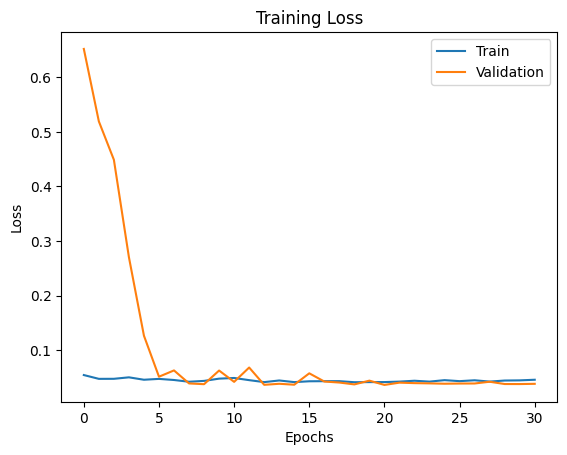

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [18]:
predict_test = model.predict(encode_input_data_test)

122/122 [==============================] - 0s 1ms/step


In [19]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])

In [20]:
print(predict_test_data)

[[1541.7911]
 [1514.2877]
 [1364.3737]
 ...
 [3779.8167]
 [3331.5393]
 [1042.6289]]


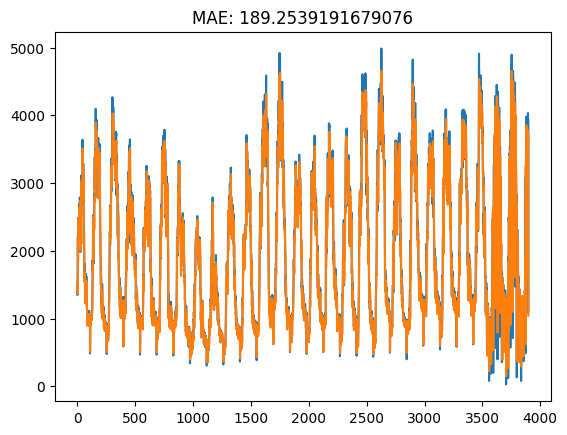

In [21]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'MAE: {np.mean(np.abs((predict_test_data-decode_output_test_data)))}')
plt.show()

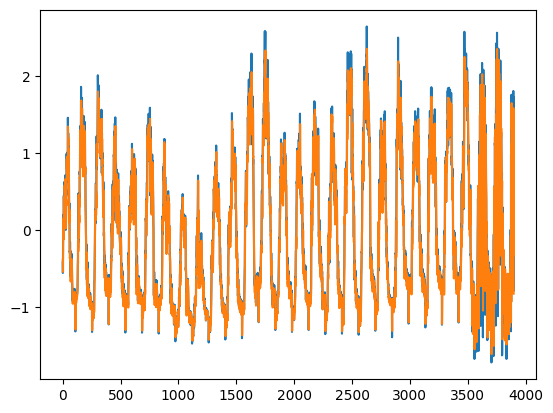

In [22]:
plt.plot(np.arange(decode_output_data_test.shape[0]), decode_output_data_test[:, -1, :])
plt.plot(np.arange(predict_test.shape[0]), predict_test[:, -1, :])
plt.show()

In [23]:
print(predict_test_data)

[[1541.7911]
 [1514.2877]
 [1364.3737]
 ...
 [3779.8167]
 [3331.5393]
 [1042.6289]]


In [24]:
print(decode_output_test_data)

[[1505.]
 [1348.]
 [1655.]
 ...
 [3556.]
 [1082.]
 [3937.]]


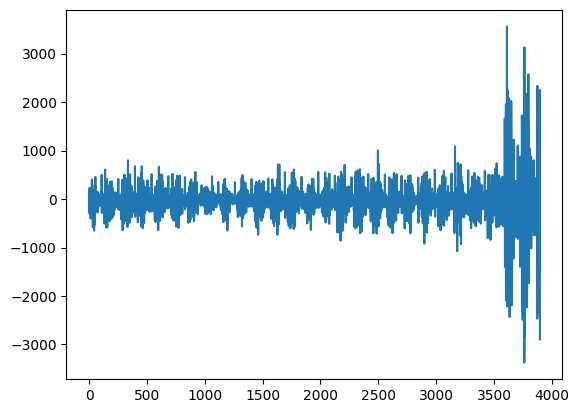

In [25]:
plt.plot(np.arange(decode_output_test_data.shape[0]), predict_test_data-decode_output_test_data)

In [26]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(decode_output_test_data, predict_test_data))

189.2539191679076
